In [1]:
import numpy as np
import gymnasium as gym
from blackjack import BlackjackEnv 
import matplotlib.pyplot as plt
import math

def state_to_key(state):
    """
    Recursively convert state to a hashable tuple.
    This handles nested lists, tuples, and numpy arrays.
    """
    if isinstance(state, np.ndarray):
        return tuple(state.tolist())
    elif isinstance(state, (list, tuple)):
        return tuple(state_to_key(s) for s in state)
    else:
        return state

def choose_action(state, Q, n_actions, epsilon):
    """
    Chooses an action using an epsilon-greedy policy.
    Initializes unseen states in Q with zeros.
    """
    if state not in Q:
        Q[state] = np.zeros(n_actions)
    if np.random.rand() < epsilon:
        return np.random.choice(n_actions)
    else:
        return np.argmax(Q[state])

def run_training(initial_epsilon, num_train_episodes, alpha, gamma):
    """
    Runs Q-learning training on the Blackjack environment with decaying epsilon.
    
    The epsilon decays by 1% every floor(num_train_episodes/100) episodes until it reaches 0.15.
    
    Parameters:
        initial_epsilon    : Starting epsilon value for exploration.
        num_train_episodes : Total number of training episodes.
        alpha              : Learning rate.
        gamma              : Discount factor.
        
    Returns:
        Q - the learned Q-table (dictionary)
        training_rewards - list with the total reward per episode during training
    """
    env = BlackjackEnv(render_mode=None, natural=False, sab=False)
    n_actions = env.action_space.n
    Q = {}
    training_rewards = []
    epsilon = initial_epsilon

    # Determine how many episodes per decay update
    block_size = max(1, num_train_episodes // 100)

    print(f"\nStarting training: {num_train_episodes} episodes, initial epsilon={epsilon}")
    for episode in range(num_train_episodes):
        obs, info = env.reset()
        state = state_to_key(obs)
        episode_reward = 0.0
        done = False

        while not done:
            action = choose_action(state, Q, n_actions, epsilon)
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = state_to_key(next_obs)
            
            # Initialize Q-values for unseen states
            if state not in Q:
                Q[state] = np.zeros(n_actions)
            if next_state not in Q:
                Q[next_state] = np.zeros(n_actions)
            
            # Q-learning update
            old_value = Q[state][action]
            next_max = np.max(Q[next_state])
            Q[state][action] = old_value + alpha * (reward + gamma * next_max - old_value)
            
            state = next_state
            episode_reward += reward

        training_rewards.append(episode_reward)
        
        # Decay epsilon every block_size episodes by 1% until it reaches 0.15.
        if (episode + 1) % block_size == 0 and epsilon > 0.15:
            epsilon = max(epsilon * 0.99, 0.15)
        
        # Print progress at 10% intervals.
        if (episode + 1) % (num_train_episodes // 10) == 0:
            print(f"  Episode {episode + 1}/{num_train_episodes} completed, current epsilon: {epsilon:.4f}")

    env.close()
    return Q, training_rewards

def evaluate_policy(Q, num_eval_episodes):
    """
    Evaluates the learned policy (greedy with respect to Q) over a number of episodes.
    
    Returns:
        avg_reward - average reward per episode,
        win_rate   - percentage of episodes with a win,
        bust_count, push_count, loss_count - counts for the different outcomes.
    """
    env = BlackjackEnv(render_mode=None, natural=False, sab=False)
    n_actions = env.action_space.n
    total_reward = 0.0
    win_count = 0
    bust_count = 0
    push_count = 0
    loss_count = 0

    for _ in range(num_eval_episodes):
        obs, info = env.reset()
        state = state_to_key(obs)
        done = False
        episode_reward = 0.0

        while not done:
            # Use greedy action (epsilon = 0) during evaluation.
            if state not in Q:
                Q[state] = np.zeros(n_actions)
            action = np.argmax(Q[state])
            next_obs, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            state = state_to_key(next_obs)
            done = terminated or truncated

        total_reward += episode_reward

        # Determine outcome based on reward and whether the hand is bust.
        if env.is_bust(env.current_hand):
            bust_count += 1
        elif episode_reward > 0.0:
            win_count += 1
        elif episode_reward == 0.0:
            push_count += 1
        elif episode_reward <= 0.0:
            loss_count += 1

    env.close()
    avg_reward = total_reward / num_eval_episodes
    win_rate = win_count / num_eval_episodes * 100
    return avg_reward, win_rate, bust_count, push_count, loss_count


Starting training: 100000 episodes, epsilon=0.9
  Episode 10000/100000 completed.
  Episode 20000/100000 completed.
  Episode 30000/100000 completed.
  Episode 40000/100000 completed.
  Episode 50000/100000 completed.
  Episode 60000/100000 completed.
  Episode 70000/100000 completed.
  Episode 80000/100000 completed.
  Episode 90000/100000 completed.
  Episode 100000/100000 completed.


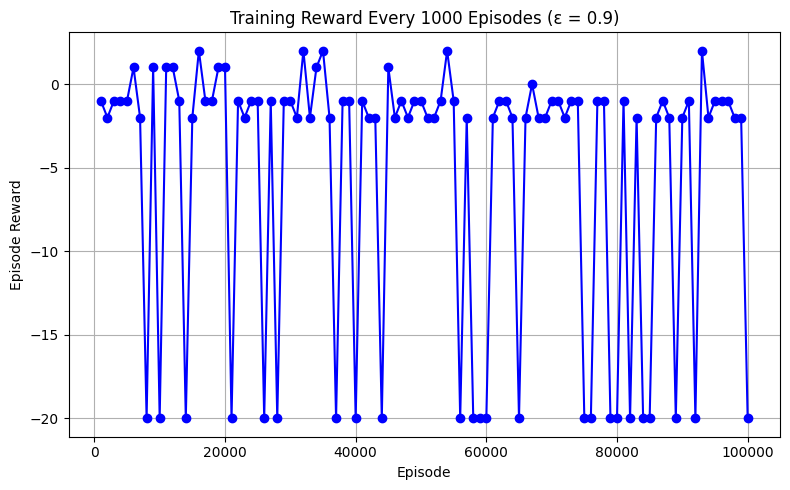

In [32]:
# Q-learning hyperparameters
alpha = 0.01       # Learning rate
gamma = 1.0        # Discount factor
num_eval_episodes = 10000  # Number of episodes for evaluation

### Experiment 1: Plot training reward from every 1000th episode (ε = 0.6)
epsilon_fixed = 0.9
num_train_episodes_exp1 = 100000
Q1, training_rewards = run_training(epsilon_fixed, num_train_episodes_exp1, alpha, gamma)

# Down-sample the training rewards to get one value every 1000 episodes.
step = 1000
sampled_episodes = np.arange(step, num_train_episodes_exp1 + 1, step)
sampled_rewards = [training_rewards[i - 1] for i in sampled_episodes]  # i-1 because indexing starts at 0

plt.figure(figsize=(8, 5))
plt.plot(sampled_episodes, sampled_rewards, marker='o', linestyle='-', color='blue')
plt.title("Training Reward Every 1000 Episodes (ε = 0.9)")
plt.xlabel("Episode")
plt.ylabel("Episode Reward")
plt.grid(True)
plt.tight_layout()
plt.show()


Starting Experiment 2: Varying epsilon to record win rate.

Training with epsilon = 0.00

Starting training: 200000 episodes, epsilon=0.0
  Episode 20000/200000 completed.
  Episode 40000/200000 completed.
  Episode 60000/200000 completed.
  Episode 80000/200000 completed.
  Episode 100000/200000 completed.
  Episode 120000/200000 completed.
  Episode 140000/200000 completed.
  Episode 160000/200000 completed.
  Episode 180000/200000 completed.
  Episode 200000/200000 completed.

Training with epsilon = 0.05

Starting training: 200000 episodes, epsilon=0.05263157894736842
  Episode 20000/200000 completed.
  Episode 40000/200000 completed.
  Episode 60000/200000 completed.
  Episode 80000/200000 completed.
  Episode 100000/200000 completed.
  Episode 120000/200000 completed.
  Episode 140000/200000 completed.
  Episode 160000/200000 completed.
  Episode 180000/200000 completed.
  Episode 200000/200000 completed.

Training with epsilon = 0.11

Starting training: 200000 episodes, epsilon

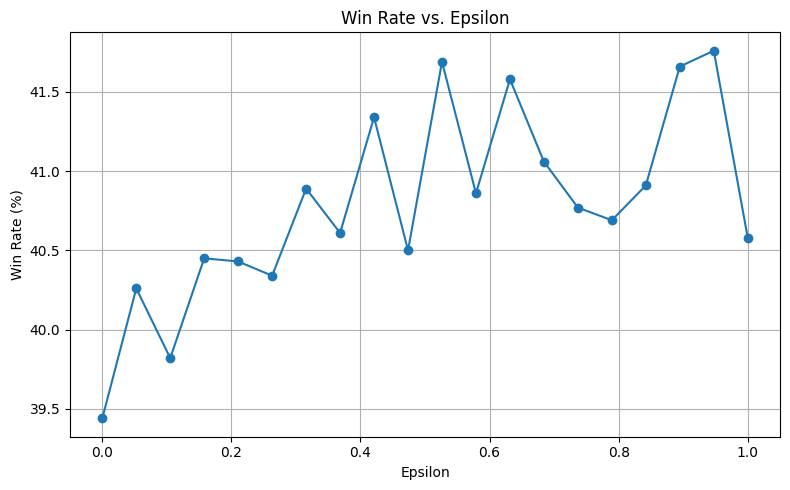

In [27]:
### Experiment 2: Plot win rate versus different epsilon values
# Use 20 epsilon values from 0.0 to 1.0 (inclusive).
epsilons = np.linspace(0.0, 1.0, 20)
win_rates = []
num_train_episodes_exp2 = 200000  # You can adjust this if needed.

print("\nStarting Experiment 2: Varying epsilon to record win rate.")
for eps in epsilons:
    print(f"\nTraining with epsilon = {eps:.2f}")
    Q_temp, _ = run_training(eps, num_train_episodes_exp2, alpha, gamma)
    _, win_rate, _, _, _ = evaluate_policy(Q_temp, num_eval_episodes)
    win_rates.append(win_rate)

plt.figure(figsize=(8, 5))
plt.plot(epsilons, win_rates, marker='o')
plt.title("Win Rate vs. Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Win Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
# Define hyperparameters
alpha = 0.1        # learning rate
gamma = 1.0        # discount factor
num_eval_episodes = 100000  # number of evaluation episodes

# Experiment 3: Plot win rate versus different numbers of training episodes using revised decaying epsilon
episodes_list = [1000, 5000, 10000, 50000, 100000, 200000, 500000, 1000000, 1500000, 2000000]
win_rates = []

print("\nStarting Experiment 3: Varying number of training episodes (ε = 0.9 decaying by 1% every floor(total_train_episodes/100) episodes until 0.15).")
for episodes in episodes_list:
    print(f"\nTraining with {episodes} episodes")
    # Call the revised training function with the specified decaying epsilon parameters.
    Q_temp, _ = run_training(initial_epsilon=1.0, num_train_episodes=episodes, 
                             alpha=alpha, gamma=gamma)
    
    avg_reward, win_rate, _, _, _ = evaluate_policy(Q_temp, num_eval_episodes)
    win_rates.append(win_rate)
    print(f"  Evaluation: Avg. Reward = {avg_reward:.3f}, Win Rate = {win_rate:.2f}%")

plt.figure(figsize=(8, 5))
plt.plot(episodes_list, win_rates, marker='o', linestyle='-')
plt.title("Win Rate vs. Training Episodes (ε decays to 0.15)")
plt.xlabel("Number of Training Episodes")
plt.ylabel("Win Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


Starting Experiment 3: Varying number of training episodes (ε = 0.9 decaying by 1% every floor(total_train_episodes/100) episodes until 0.15).

Training with 1000 episodes

Starting training: 1000 episodes, initial epsilon=1.0
  Episode 100/1000 completed, current epsilon: 0.9044
  Episode 200/1000 completed, current epsilon: 0.8179
  Episode 300/1000 completed, current epsilon: 0.7397
  Episode 400/1000 completed, current epsilon: 0.6690
  Episode 500/1000 completed, current epsilon: 0.6050
  Episode 600/1000 completed, current epsilon: 0.5472
  Episode 700/1000 completed, current epsilon: 0.4948
  Episode 800/1000 completed, current epsilon: 0.4475
  Episode 900/1000 completed, current epsilon: 0.4047
  Episode 1000/1000 completed, current epsilon: 0.3660


AttributeError: 'BlackjackEnv' object has no attribute 'current_hand'

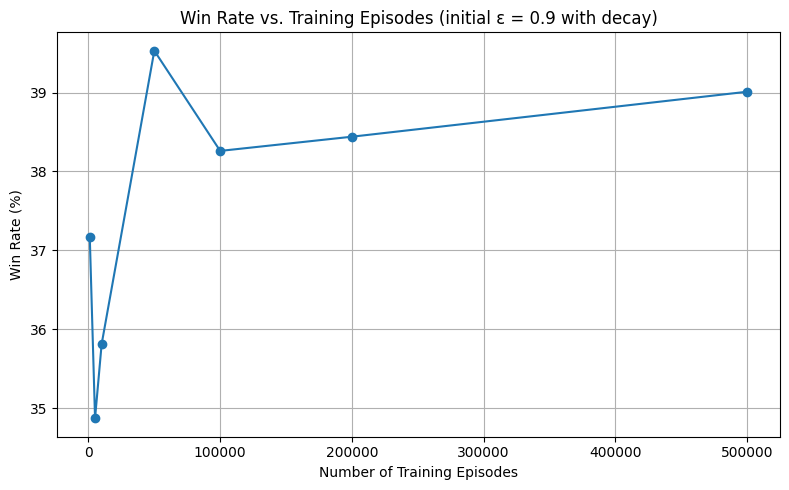

In [4]:
plt.figure(figsize=(8, 5))
plt.plot(episodes_list, win_rates, marker='o', linestyle='-')
plt.title("Win Rate vs. Training Episodes (initial ε = 0.9 with decay)")
plt.xlabel("Number of Training Episodes")
plt.ylabel("Win Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
import numpy as np
import gymnasium as gym
from blackjack import BlackjackEnv 
import matplotlib.pyplot as plt

def state_to_key(state):
    """
    Recursively convert state to a hashable tuple.
    This handles nested lists, tuples, and numpy arrays.
    """
    if isinstance(state, np.ndarray):
        return tuple(state.tolist())
    elif isinstance(state, (list, tuple)):
        return tuple(state_to_key(s) for s in state)
    else:
        return state

def choose_action(state, Q, n_actions, epsilon):
    """
    Chooses an action using an epsilon-greedy policy.
    Initializes unseen states in Q with zeros.
    """
    if state not in Q:
        Q[state] = np.zeros(n_actions)
    if np.random.rand() < epsilon:
        return np.random.choice(n_actions)
    else:
        return np.argmax(Q[state])

def run_training(initial_epsilon, num_train_episodes, alpha, gamma, epsilon_decay=0.995, epsilon_min=0.01):
    """
    Runs Q-learning training on the Blackjack environment with decaying epsilon.
    
    Parameters:
        initial_epsilon : starting epsilon value for exploration.
        num_train_episodes: number of training episodes.
        alpha : learning rate.
        gamma : discount factor.
        epsilon_decay : multiplicative decay factor per episode.
        epsilon_min : minimum allowed epsilon.
        
    Returns:
        Q - the learned Q-table (dictionary)
        training_rewards - list with the total reward per episode during training
    """
    env = BlackjackEnv(render_mode=None, natural=False, sab=False)
    n_actions = env.action_space.n
    Q = {}
    training_rewards = []
    epsilon = initial_epsilon

    print(f"\nStarting training: {num_train_episodes} episodes, initial epsilon={epsilon}")
    for episode in range(num_train_episodes):
        obs, info = env.reset()
        state = state_to_key(obs)
        episode_reward = 0.0
        done = False

        while not done:
            action = choose_action(state, Q, n_actions, epsilon)
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = state_to_key(next_obs)
            
            # Initialize Q-values for unseen states
            if state not in Q:
                Q[state] = np.zeros(n_actions)
            if next_state not in Q:
                Q[next_state] = np.zeros(n_actions)
            
            # Q-learning update
            old_value = Q[state][action]
            next_max = np.max(Q[next_state])
            Q[state][action] = old_value + alpha * (reward + gamma * next_max - old_value)
            
            state = next_state
            episode_reward += reward

        training_rewards.append(episode_reward)
        
        # Decay epsilon after each episode
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        
        # Print progress at 10% intervals.
        if (episode + 1) % (num_train_episodes // 10) == 0:
            print(f"  Episode {episode + 1}/{num_train_episodes} completed, current epsilon: {epsilon:.4f}")

    env.close()
    return Q, training_rewards

def evaluate_policy(Q, num_eval_episodes):
    """
    Evaluates the learned policy (greedy with respect to Q) over a number of episodes.
    
    Returns:
        avg_reward - average reward per episode,
        win_rate   - percentage of episodes with a win,
        bust_count, push_count, loss_count - counts for the different outcomes.
    """
    env = BlackjackEnv(render_mode=None, natural=False, sab=False)
    n_actions = env.action_space.n
    total_reward = 0.0
    win_count = 0
    bust_count = 0
    push_count = 0
    loss_count = 0

    for _ in range(num_eval_episodes):
        obs, info = env.reset()
        state = state_to_key(obs)
        done = False
        episode_reward = 0.0

        while not done:
            # Use greedy action (epsilon = 0) during evaluation.
            if state not in Q:
                Q[state] = np.zeros(n_actions)
            action = np.argmax(Q[state])
            next_obs, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            state = state_to_key(next_obs)
            done = terminated or truncated

        total_reward += episode_reward

        # Determine outcome based on reward and whether the hand is bust.
        if env.is_bust(env.current_hand):
            bust_count += 1
        elif episode_reward > 0.0:
            win_count += 1
        elif episode_reward == 0.0:
            push_count += 1
        elif episode_reward <= 0.0:
            loss_count += 1

    env.close()
    avg_reward = total_reward / num_eval_episodes
    win_rate = win_count / num_eval_episodes * 100
    return avg_reward, win_rate, bust_count, push_count, loss_count


Starting Experiment 3: Varying number of training episodes (ε = 0.9 with decay).

Training with 1000 episodes

Starting training: 1000 episodes, initial epsilon=1
  Episode 100/1000 completed, current epsilon: 0.3660
  Episode 200/1000 completed, current epsilon: 0.1340
  Episode 300/1000 completed, current epsilon: 0.1000
  Episode 400/1000 completed, current epsilon: 0.1000
  Episode 500/1000 completed, current epsilon: 0.1000
  Episode 600/1000 completed, current epsilon: 0.1000
  Episode 700/1000 completed, current epsilon: 0.1000
  Episode 800/1000 completed, current epsilon: 0.1000
  Episode 900/1000 completed, current epsilon: 0.1000
  Episode 1000/1000 completed, current epsilon: 0.1000
  Evaluation: Avg. Reward = -0.456, Win Rate = 36.94%

Training with 5000 episodes

Starting training: 5000 episodes, initial epsilon=1
  Episode 500/5000 completed, current epsilon: 0.1000
  Episode 1000/5000 completed, current epsilon: 0.1000
  Episode 1500/5000 completed, current epsilon: 0.

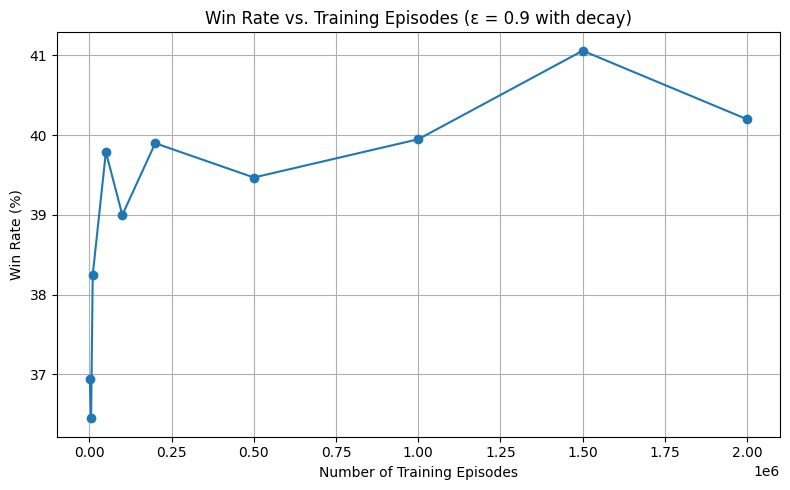

In [17]:
# Define any hyperparameters if not already defined
alpha = 0.1        # learning rate
gamma = 1       # discount factor
num_eval_episodes = 10000  # number of evaluation episodes

# Experiment 3: Plot win rate versus different numbers of training episodes using decaying epsilon
episodes_list = [1000, 5000, 10000, 50000, 100000, 200000, 500000, 1000000, 1500000, 2000000]
win_rates = []

print("\nStarting Experiment 3: Varying number of training episodes (ε = 0.9 with decay).")
for episodes in episodes_list:
    print(f"\nTraining with {episodes} episodes")
    # Use decaying epsilon: initial_epsilon = 0.9, epsilon_decay and epsilon_min as specified.
    Q_temp, _ = run_training(initial_epsilon=1, num_train_episodes=episodes, 
                             alpha=alpha, gamma=gamma, epsilon_decay=0.99, epsilon_min=0.1)
    
    avg_reward, win_rate, _, _, _ = evaluate_policy(Q_temp, num_eval_episodes)
    win_rates.append(win_rate)
    print(f"  Evaluation: Avg. Reward = {avg_reward:.3f}, Win Rate = {win_rate:.2f}%")

plt.figure(figsize=(8, 5))
plt.plot(episodes_list, win_rates, marker='o', linestyle='-')
plt.title("Win Rate vs. Training Episodes (ε = 0.9 with decay)")
plt.xlabel("Number of Training Episodes")
plt.ylabel("Win Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


Starting Experiment 3: Varying number of training episodes (ε = 0.9 decaying by 1% every floor(total_train_episodes/100) episodes until 0.15).

Training with 1000 episodes

Starting training: 1000 episodes, initial epsilon=1.0
  Episode 100/1000 completed, current epsilon: 1.0000
  Episode 200/1000 completed, current epsilon: 1.0000
  Episode 300/1000 completed, current epsilon: 1.0000
  Episode 400/1000 completed, current epsilon: 0.9900
  Episode 500/1000 completed, current epsilon: 0.9801
  Episode 600/1000 completed, current epsilon: 0.9703
  Episode 700/1000 completed, current epsilon: 0.9606
  Episode 800/1000 completed, current epsilon: 0.9510
  Episode 900/1000 completed, current epsilon: 0.9415
  Episode 1000/1000 completed, current epsilon: 0.9321
  Evaluation: Avg. Reward = -0.305, Win Rate = 37.66%

Training with 5000 episodes

Starting training: 5000 episodes, initial epsilon=1.0
  Episode 500/5000 completed, current epsilon: 0.9801
  Episode 1000/5000 completed, current 

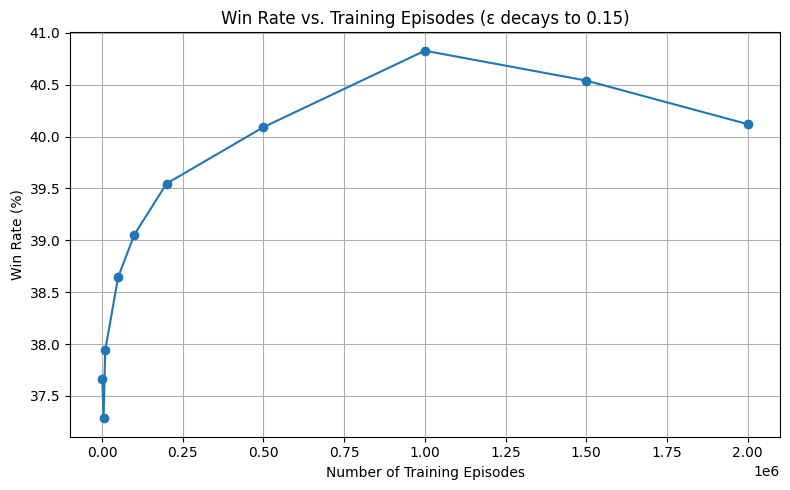

In [20]:
# Define hyperparameters
alpha = 0.1        # learning rate
gamma = 1.0        # discount factor
num_eval_episodes = 100000  # number of evaluation episodes

# Experiment 3: Plot win rate versus different numbers of training episodes using revised decaying epsilon
episodes_list = [1000, 5000, 10000, 50000, 100000, 200000, 500000, 1000000, 1500000, 2000000]
win_rates = []

print("\nStarting Experiment 3: Varying number of training episodes (ε = 0.9 decaying by 1% every floor(total_train_episodes/100) episodes until 0.15).")
for episodes in episodes_list:
    print(f"\nTraining with {episodes} episodes")
    # Call the revised training function with the specified decaying epsilon parameters.
    Q_temp, _ = run_training(initial_epsilon=1.0, num_train_episodes=episodes, 
                             alpha=alpha, gamma=gamma)
    
    avg_reward, win_rate, _, _, _ = evaluate_policy(Q_temp, num_eval_episodes)
    win_rates.append(win_rate)
    print(f"  Evaluation: Avg. Reward = {avg_reward:.3f}, Win Rate = {win_rate:.2f}%")

plt.figure(figsize=(8, 5))
plt.plot(episodes_list, win_rates, marker='o', linestyle='-')
plt.title("Win Rate vs. Training Episodes (ε decays to 0.15)")
plt.xlabel("Number of Training Episodes")
plt.ylabel("Win Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import gymnasium as gym
from blackjack import BlackjackEnv 
import matplotlib.pyplot as plt
import math

def state_to_key(state):
    """
    Recursively convert state to a hashable tuple.
    This handles nested lists, tuples, and numpy arrays.
    """
    if isinstance(state, np.ndarray):
        return tuple(state.tolist())
    elif isinstance(state, (list, tuple)):
        return tuple(state_to_key(s) for s in state)
    else:
        return state

def choose_action(state, Q, n_actions, epsilon):
    """
    Chooses an action using an epsilon-greedy policy.
    Initializes unseen states in Q with zeros.
    """
    if state not in Q:
        Q[state] = np.zeros(n_actions)
    if np.random.rand() < epsilon:
        return np.random.choice(n_actions)
    else:
        return np.argmax(Q[state])

def run_training(initial_epsilon, num_train_episodes, alpha, gamma):
    """
    Runs Q-learning training on the Blackjack environment with adaptive epsilon decay.
    
    Epsilon decays by 1% (until reaching 0.15) only after the rolling average reward
    (computed over the last 100 episodes) has not increased for more than 100 episodes.
    
    Parameters:
        initial_epsilon    : Starting epsilon value for exploration.
        num_train_episodes : Total number of training episodes.
        alpha              : Learning rate.
        gamma              : Discount factor.
        
    Returns:
        Q - the learned Q-table (dictionary)
        training_rewards - list with the total reward per episode during training
    """
    env = BlackjackEnv(render_mode=None, natural=False, sab=False)
    n_actions = env.action_space.n
    Q = {}
    training_rewards = []
    epsilon = initial_epsilon

    # Variables to track improvement in the rolling average reward
    best_rolling_avg = -np.inf
    episodes_since_improvement = 0

    print(f"\nStarting training: {num_train_episodes} episodes, initial epsilon={epsilon}")
    for episode in range(num_train_episodes):
        obs, info = env.reset()
        state = state_to_key(obs)
        episode_reward = 0.0
        done = False

        while not done:
            action = choose_action(state, Q, n_actions, epsilon)
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = state_to_key(next_obs)
            
            # Initialize Q-values for unseen states
            if state not in Q:
                Q[state] = np.zeros(n_actions)
            if next_state not in Q:
                Q[next_state] = np.zeros(n_actions)
            
            # Q-learning update
            old_value = Q[state][action]
            next_max = np.max(Q[next_state])
            Q[state][action] = old_value + alpha * (reward + gamma * next_max - old_value)
            
            state = next_state
            episode_reward += reward

        training_rewards.append(episode_reward)
        
        # Only check for improvement after at least 100 episodes
        if episode >= 100:
            current_rolling_avg = np.mean(training_rewards[-100:])
            if current_rolling_avg > best_rolling_avg:
                best_rolling_avg = current_rolling_avg
                episodes_since_improvement = 0
            else:
                episodes_since_improvement += 1
                if episodes_since_improvement > 100 and epsilon > 0.15:
                    epsilon = max(epsilon * 0.99, 0.15)
                    episodes_since_improvement = 0  # Reset the counter after decaying epsilon
        
        # Print progress at 10% intervals.
        if (episode + 1) % (num_train_episodes // 10) == 0:
            print(f"  Episode {episode + 1}/{num_train_episodes} completed, current epsilon: {epsilon:.4f}")

    env.close()
    return Q, training_rewards

def cmp(a, b):
    """Helper function for comparing scores."""
    return float(a > b) - float(a < b)

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def evaluate_policy(Q, num_eval_episodes):
    """
    Evaluates the learned policy (greedy with respect to Q) over a number of episodes.
    
    Returns:
        avg_reward - average reward per episode,
        win_rate   - percentage of hands won,
        bust_count, push_count, loss_count - counts for the different outcomes (evaluated per hand).
    """
    env = BlackjackEnv(render_mode=None, natural=False, sab=False)
    n_actions = env.action_space.n
    total_reward = 0.0
    win_count = 0
    bust_count = 0
    push_count = 0
    loss_count = 0
    total_hands = 0

    # Lists to store episodes and rewards for plotting every 1000th episode
    plot_episodes = []
    plot_rewards = []

    for i in range(num_eval_episodes):
        obs, info = env.reset()
        state = state_to_key(obs)
        episode_reward = 0.0
        done = False

        # Run episode using greedy actions
        while not done:
            if state not in Q:
                Q[state] = np.zeros(n_actions)
            action = np.argmax(Q[state])
            next_obs, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            state = state_to_key(next_obs)
            done = terminated or truncated

        total_reward += episode_reward

        # After the episode, evaluate each player hand against the dealer.
        dealer_score = env.score(env.dealer)
        for hand in env.player_hands:
            total_hands += 1
            if env.is_bust(hand):
                bust_count += 1
            else:
                outcome = cmp(env.score(hand), dealer_score)
                if outcome > 0:
                    win_count += 1
                elif outcome == 0:
                    push_count += 1
                elif outcome < 0:
                    loss_count += 1

        # Record reward only for every 1000th evaluation episode
        if (i + 1) % 1000 == 0:
            plot_episodes.append(i + 1)
            plot_rewards.append(episode_reward)

    env.close()

    # Plot reward over episodes (only every 1000th episode)
    plt.figure(figsize=(10, 5))
    plt.plot(plot_episodes, plot_rewards, marker='o', linestyle='-')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reward over Every 1000th Episode')
    plt.grid(True)
    plt.show()

    avg_reward = total_reward / num_eval_episodes
    win_rate = (win_count / total_hands * 100) if total_hands > 0 else 0
    return avg_reward, win_rate, bust_count, push_count, loss_count


Starting Experiment 3: Varying number of training episodes (ε = 0.9 decaying by 1% every floor(total_train_episodes/100) episodes until 0.15).

Training with 1000 episodes

Starting training: 1000 episodes, initial epsilon=1.0
  Episode 100/1000 completed, current epsilon: 1.0000
  Episode 200/1000 completed, current epsilon: 1.0000
  Episode 300/1000 completed, current epsilon: 1.0000
  Episode 400/1000 completed, current epsilon: 0.9900
  Episode 500/1000 completed, current epsilon: 0.9801
  Episode 600/1000 completed, current epsilon: 0.9703
  Episode 700/1000 completed, current epsilon: 0.9606
  Episode 800/1000 completed, current epsilon: 0.9510
  Episode 900/1000 completed, current epsilon: 0.9415
  Episode 1000/1000 completed, current epsilon: 0.9321


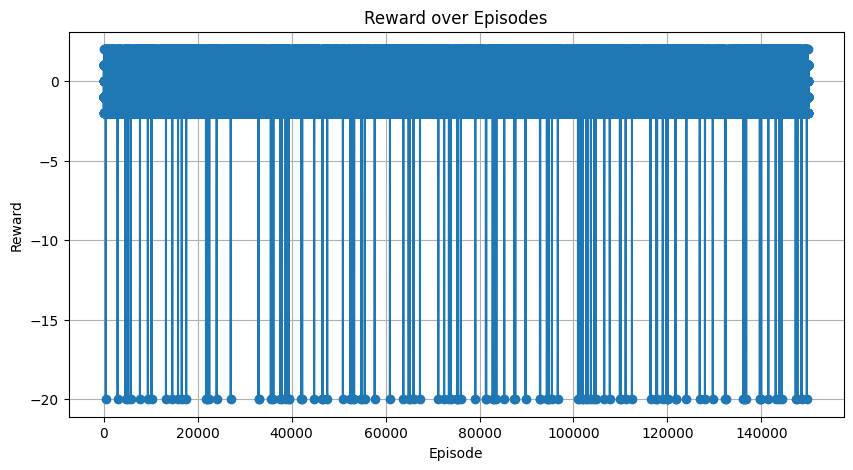

  Evaluation: Avg. Reward = -0.235, Win Rate = 37.42%

Training with 5000 episodes

Starting training: 5000 episodes, initial epsilon=1.0
  Episode 500/5000 completed, current epsilon: 0.9801
  Episode 1000/5000 completed, current epsilon: 0.9321
  Episode 1500/5000 completed, current epsilon: 0.8864
  Episode 2000/5000 completed, current epsilon: 0.8429
  Episode 2500/5000 completed, current epsilon: 0.8016
  Episode 3000/5000 completed, current epsilon: 0.7623
  Episode 3500/5000 completed, current epsilon: 0.7323
  Episode 4000/5000 completed, current epsilon: 0.6964
  Episode 4500/5000 completed, current epsilon: 0.6690
  Episode 5000/5000 completed, current epsilon: 0.6362


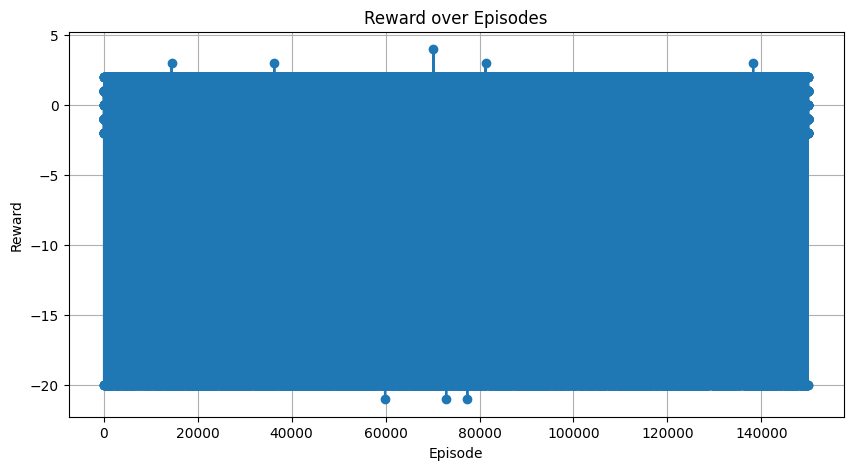

  Evaluation: Avg. Reward = -0.591, Win Rate = 37.72%

Training with 10000 episodes

Starting training: 10000 episodes, initial epsilon=1.0
  Episode 1000/10000 completed, current epsilon: 0.9321
  Episode 2000/10000 completed, current epsilon: 0.8429
  Episode 3000/10000 completed, current epsilon: 0.7857
  Episode 4000/10000 completed, current epsilon: 0.7106
  Episode 5000/10000 completed, current epsilon: 0.6426
  Episode 6000/10000 completed, current epsilon: 0.5812
  Episode 7000/10000 completed, current epsilon: 0.5256
  Episode 8000/10000 completed, current epsilon: 0.4753
  Episode 9000/10000 completed, current epsilon: 0.4342
  Episode 10000/10000 completed, current epsilon: 0.3927


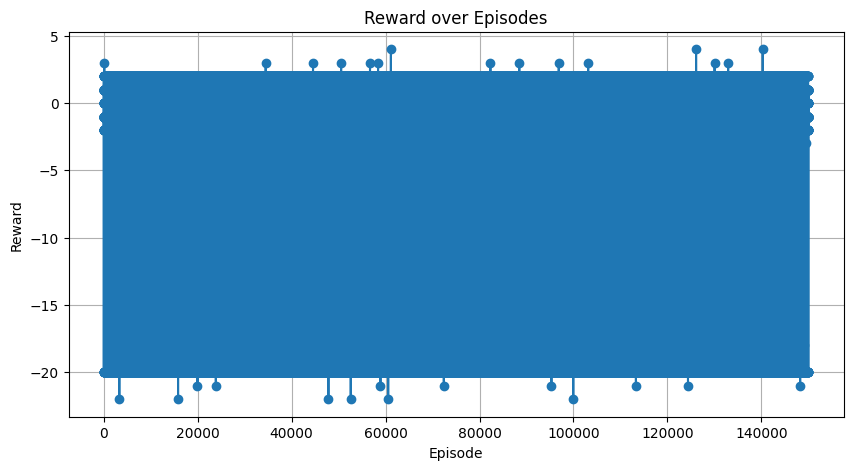

  Evaluation: Avg. Reward = -0.938, Win Rate = 38.47%

Training with 50000 episodes

Starting training: 50000 episodes, initial epsilon=1.0
  Episode 5000/50000 completed, current epsilon: 0.6557
  Episode 10000/50000 completed, current epsilon: 0.4088
  Episode 15000/50000 completed, current epsilon: 0.2498
  Episode 20000/50000 completed, current epsilon: 0.1542
  Episode 25000/50000 completed, current epsilon: 0.1500
  Episode 30000/50000 completed, current epsilon: 0.1500
  Episode 35000/50000 completed, current epsilon: 0.1500
  Episode 40000/50000 completed, current epsilon: 0.1500
  Episode 45000/50000 completed, current epsilon: 0.1500
  Episode 50000/50000 completed, current epsilon: 0.1500


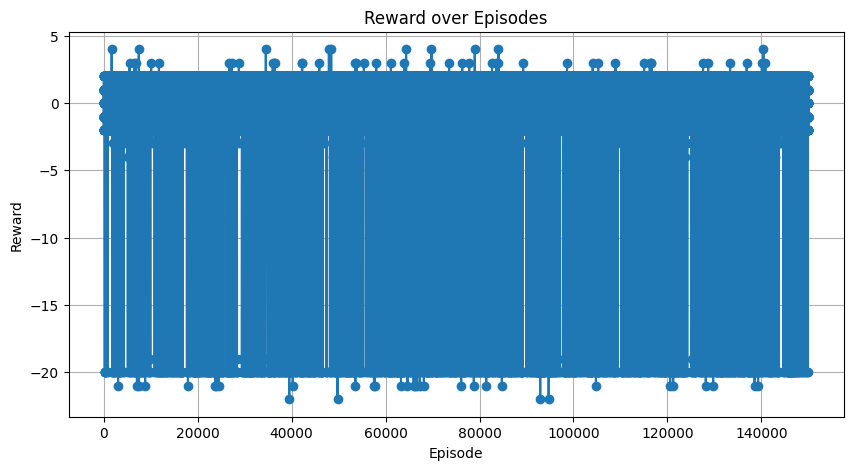

  Evaluation: Avg. Reward = -0.301, Win Rate = 39.32%

Training with 100000 episodes

Starting training: 100000 episodes, initial epsilon=1.0
  Episode 10000/100000 completed, current epsilon: 0.4007
  Episode 20000/100000 completed, current epsilon: 0.1512
  Episode 30000/100000 completed, current epsilon: 0.1500
  Episode 40000/100000 completed, current epsilon: 0.1500
  Episode 50000/100000 completed, current epsilon: 0.1500
  Episode 60000/100000 completed, current epsilon: 0.1500
  Episode 70000/100000 completed, current epsilon: 0.1500
  Episode 80000/100000 completed, current epsilon: 0.1500
  Episode 90000/100000 completed, current epsilon: 0.1500
  Episode 100000/100000 completed, current epsilon: 0.1500


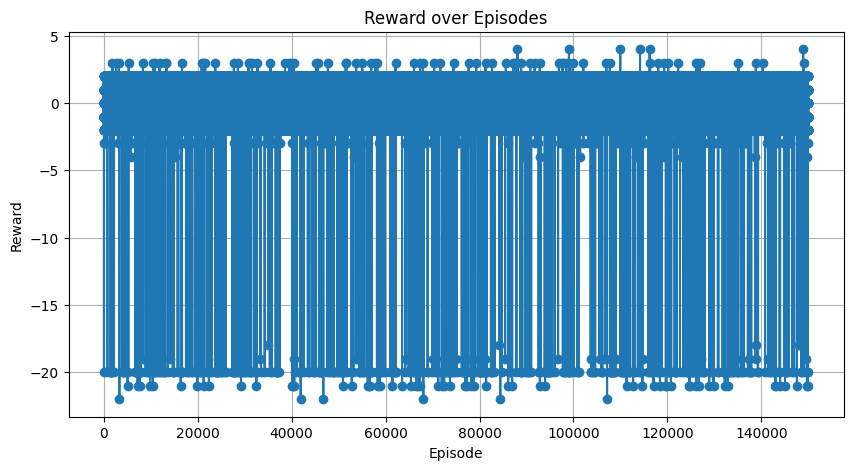

  Evaluation: Avg. Reward = -0.221, Win Rate = 39.31%

Training with 200000 episodes

Starting training: 200000 episodes, initial epsilon=1.0
  Episode 20000/200000 completed, current epsilon: 0.1527
  Episode 40000/200000 completed, current epsilon: 0.1500
  Episode 60000/200000 completed, current epsilon: 0.1500
  Episode 80000/200000 completed, current epsilon: 0.1500
  Episode 100000/200000 completed, current epsilon: 0.1500
  Episode 120000/200000 completed, current epsilon: 0.1500
  Episode 140000/200000 completed, current epsilon: 0.1500
  Episode 160000/200000 completed, current epsilon: 0.1500
  Episode 180000/200000 completed, current epsilon: 0.1500
  Episode 200000/200000 completed, current epsilon: 0.1500


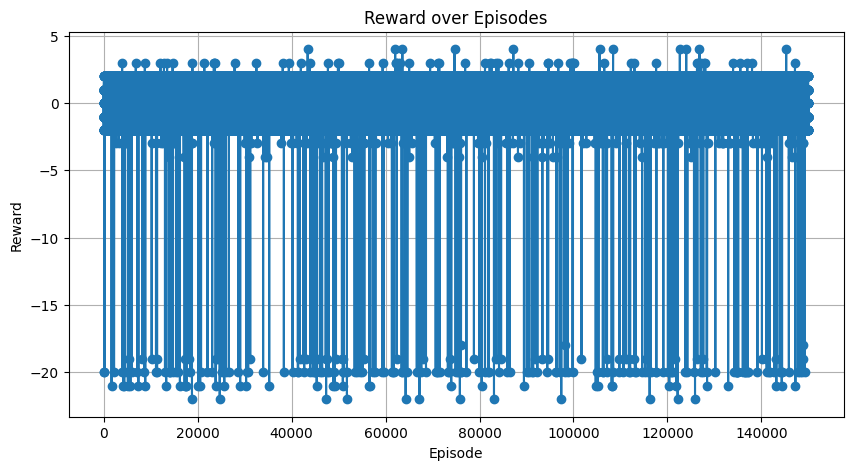

  Evaluation: Avg. Reward = -0.200, Win Rate = 39.09%

Training with 500000 episodes

Starting training: 500000 episodes, initial epsilon=1.0
  Episode 50000/500000 completed, current epsilon: 0.1500
  Episode 100000/500000 completed, current epsilon: 0.1500
  Episode 150000/500000 completed, current epsilon: 0.1500
  Episode 200000/500000 completed, current epsilon: 0.1500
  Episode 250000/500000 completed, current epsilon: 0.1500
  Episode 300000/500000 completed, current epsilon: 0.1500
  Episode 350000/500000 completed, current epsilon: 0.1500
  Episode 400000/500000 completed, current epsilon: 0.1500
  Episode 450000/500000 completed, current epsilon: 0.1500
  Episode 500000/500000 completed, current epsilon: 0.1500


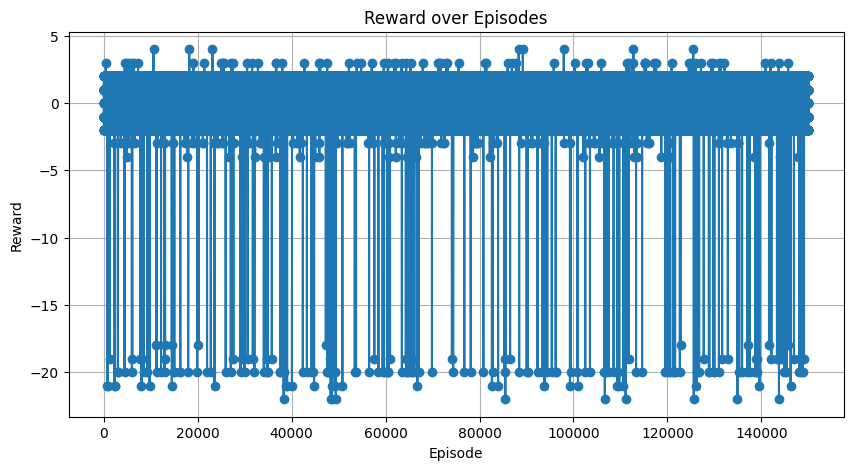

  Evaluation: Avg. Reward = -0.187, Win Rate = 40.29%

Training with 1000000 episodes

Starting training: 1000000 episodes, initial epsilon=1.0
  Episode 100000/1000000 completed, current epsilon: 0.1500
  Episode 200000/1000000 completed, current epsilon: 0.1500
  Episode 300000/1000000 completed, current epsilon: 0.1500
  Episode 400000/1000000 completed, current epsilon: 0.1500
  Episode 500000/1000000 completed, current epsilon: 0.1500
  Episode 600000/1000000 completed, current epsilon: 0.1500
  Episode 700000/1000000 completed, current epsilon: 0.1500
  Episode 800000/1000000 completed, current epsilon: 0.1500
  Episode 900000/1000000 completed, current epsilon: 0.1500
  Episode 1000000/1000000 completed, current epsilon: 0.1500


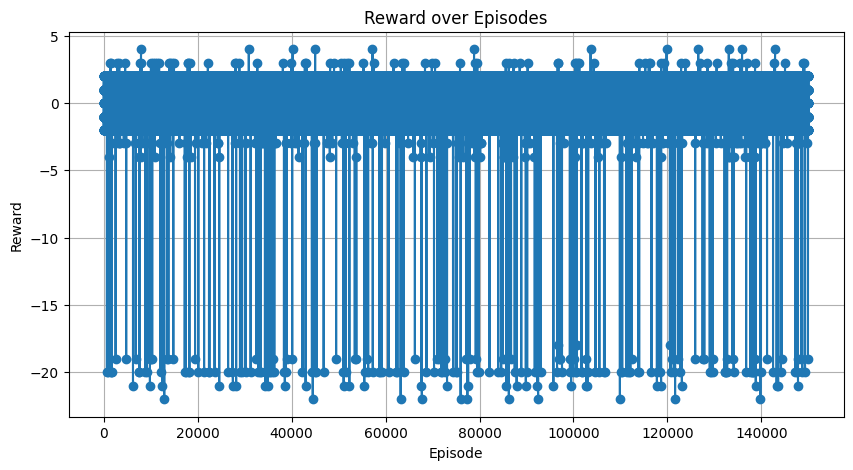

  Evaluation: Avg. Reward = -0.173, Win Rate = 41.12%


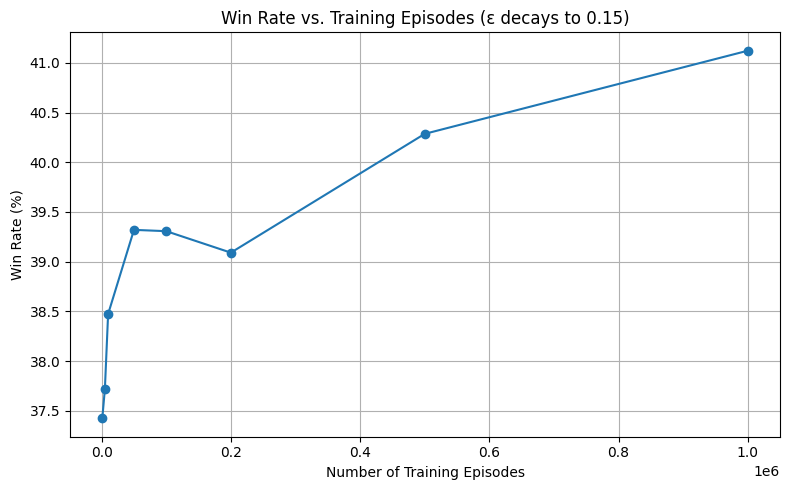

In [3]:
# Define hyperparameters
alpha = 0.1        # learning rate
gamma = 1.0        # discount factor
num_eval_episodes = 150000  # number of evaluation episodes

# Experiment 3: Plot win rate versus different numbers of training episodes using revised decaying epsilon
episodes_list = [1000, 5000, 10000, 50000, 100000, 200000, 500000, 1000000]
win_rates = []

print("\nStarting Experiment 3: Varying number of training episodes (ε = 0.9 decaying by 1% every floor(total_train_episodes/100) episodes until 0.15).")
for episodes in episodes_list:
    print(f"\nTraining with {episodes} episodes")
    # Call the revised training function with the specified decaying epsilon parameters.
    Q_temp, _ = run_training(initial_epsilon=1.0, num_train_episodes=episodes, 
                             alpha=alpha, gamma=gamma)
    
    avg_reward, win_rate, _, _, _ = evaluate_policy(Q_temp, num_eval_episodes)
    win_rates.append(win_rate)
    print(f"  Evaluation: Avg. Reward = {avg_reward:.3f}, Win Rate = {win_rate:.2f}%")

plt.figure(figsize=(8, 5))
plt.plot(episodes_list, win_rates, marker='o', linestyle='-')
plt.title("Win Rate vs. Training Episodes (ε decays to 0.15)")
plt.xlabel("Number of Training Episodes")
plt.ylabel("Win Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

### LEARING RATE SCHEUDLER TRAINING APPROACH

In [5]:
def run_training(initial_epsilon, num_train_episodes, alpha, gamma):
    """
    Runs Q-learning training on the Blackjack environment with adaptive epsilon decay.
    
    Epsilon decays by 1% (until reaching 0.15) only after the rolling average reward
    (computed over the last 10% of training episodes) has not increased for 10% of training episodes.
    
    Parameters:
        initial_epsilon    : Starting epsilon value for exploration.
        num_train_episodes : Total number of training episodes.
        alpha              : Learning rate.
        gamma              : Discount factor.
        
    Returns:
        Q - the learned Q-table (dictionary)
        training_rewards - list with the total reward per episode during training
    """
    env = BlackjackEnv(render_mode=None, natural=False, sab=False)
    n_actions = env.action_space.n
    Q = {}
    training_rewards = []
    epsilon = initial_epsilon

    # Set rolling window and wait threshold to 10% of total training episodes.
    rolling_window = int(0.1 * num_train_episodes)
    wait_threshold = int(0.1 * num_train_episodes)
    best_rolling_avg = -np.inf
    episodes_since_improvement = 0

    print(f"\nStarting training: {num_train_episodes} episodes, initial epsilon={epsilon}")
    for episode in range(num_train_episodes):
        obs, info = env.reset()
        state = state_to_key(obs)
        episode_reward = 0.0
        done = False

        while not done:
            action = choose_action(state, Q, n_actions, epsilon)
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = state_to_key(next_obs)
            
            # Initialize Q-values for unseen states
            if state not in Q:
                Q[state] = np.zeros(n_actions)
            if next_state not in Q:
                Q[next_state] = np.zeros(n_actions)
            
            # Q-learning update
            old_value = Q[state][action]
            next_max = np.max(Q[next_state])
            Q[state][action] = old_value + alpha * (reward + gamma * next_max - old_value)
            
            state = next_state
            episode_reward += reward

        training_rewards.append(episode_reward)
        
        # Only check for improvement after at least "rolling_window" episodes
        if episode >= rolling_window:
            current_rolling_avg = np.mean(training_rewards[-rolling_window:])
            if current_rolling_avg > best_rolling_avg:
                best_rolling_avg = current_rolling_avg
                episodes_since_improvement = 0
            else:
                episodes_since_improvement += 1
                if episodes_since_improvement >= wait_threshold and epsilon > 0.15:
                    epsilon = max(epsilon * 0.99, 0.15)
                    episodes_since_improvement = 0  # Reset the counter after decaying epsilon
        
        # Print progress at 10% intervals.
        if (episode + 1) % (num_train_episodes // 10) == 0:
            print(f"  Episode {episode + 1}/{num_train_episodes} completed, current epsilon: {epsilon:.4f}")

    env.close()
    return Q, training_rewards


Starting Experiment 3: Varying training episodes with adaptive epsilon decay (ε decays by 1% every 10% of training episodes if no improvement, until reaching 0.15).

Training with 1000 episodes

Starting training: 1000 episodes, initial epsilon=1.0
  Episode 100/1000 completed, current epsilon: 1.0000
  Episode 200/1000 completed, current epsilon: 1.0000
  Episode 300/1000 completed, current epsilon: 0.9900
  Episode 400/1000 completed, current epsilon: 0.9900
  Episode 500/1000 completed, current epsilon: 0.9801
  Episode 600/1000 completed, current epsilon: 0.9703
  Episode 700/1000 completed, current epsilon: 0.9606
  Episode 800/1000 completed, current epsilon: 0.9510
  Episode 900/1000 completed, current epsilon: 0.9415
  Episode 1000/1000 completed, current epsilon: 0.9415
  Evaluation: Avg. Reward = -0.201, Win Rate = 37.75%

Training with 5000 episodes

Starting training: 5000 episodes, initial epsilon=1.0
  Episode 500/5000 completed, current epsilon: 1.0000
  Episode 1000/50

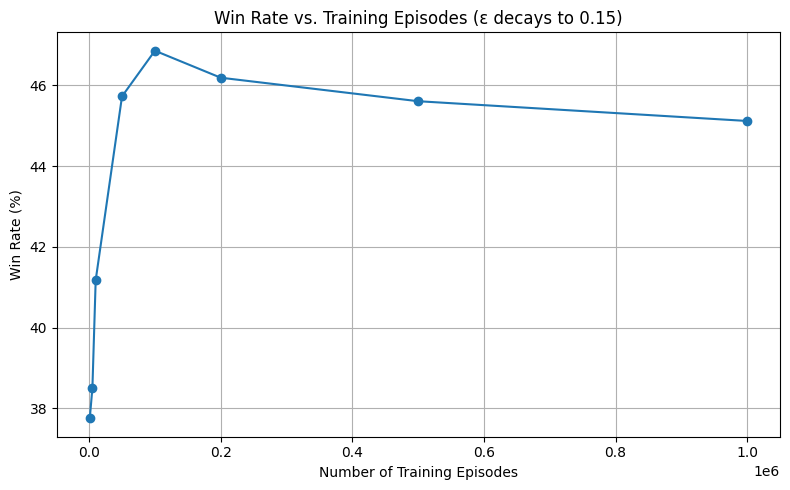

In [6]:
# --- Experiment Setup and Execution ---
# Define hyperparameters.
alpha = 0.1        # Learning rate
gamma = 1.0        # Discount factor
num_eval_episodes = 100000  # Number of evaluation episodes

# Experiment 3: Plot win rate versus different numbers of training episodes.
episodes_list = [1000, 5000, 10000, 50000, 100000, 200000, 500000, 1000000]
win_rates = []

print("\nStarting Experiment 3: Varying training episodes with adaptive epsilon decay "
      "(ε decays by 1% every 10% of training episodes if no improvement, until reaching 0.15).")
for episodes in episodes_list:
    print(f"\nTraining with {episodes} episodes")
    Q_temp, _ = run_training(initial_epsilon=1.0, num_train_episodes=episodes, 
                             alpha=alpha, gamma=gamma)
    avg_reward, win_rate, _, _, _ = evaluate_policy(Q_temp, num_eval_episodes)
    win_rates.append(win_rate)
    print(f"  Evaluation: Avg. Reward = {avg_reward:.3f}, Win Rate = {win_rate:.2f}%")

plt.figure(figsize=(8, 5))
plt.plot(episodes_list, win_rates, marker='o', linestyle='-')
plt.title("Win Rate vs. Training Episodes (ε decays to 0.15)")
plt.xlabel("Number of Training Episodes")
plt.ylabel("Win Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()